# LDA 
LDA = Latent Dirichlet Allocation <br>
Technique used for topic modelling, based on the idea that each of the documents of a collection ( = each song lyrics in the dataset) can be seen as a mixture of collection-wide topics<br>
Unsupervised technique <br>
Goal: find the topic structures (which are latent) 


In [1]:
import pandas as pd
import gensim

In [43]:
data = pd.read_csv(filepath_or_buffer='Data/Music4All-Onion/final_datasets/monolabel_df_lyrics.csv', index_col=0, usecols=[0, 1, 3])
labels = pd.read_csv(filepath_or_buffer='Data/Music4All-Onion/final_datasets/monolabel_df_lyrics.csv', index_col=None, usecols=[2])

In [12]:
data.head()

,songID,Lyrics
0,0010xmHR6UICBOYT,may think word gift wrap put posit spin world ...
1,0Yhpyv5rCNOf3SWi,obsess ocean eleven whole passion patienc circ...
3,6YlaDzr4pFMlNlLd,hoc hoc real smoker get hoc real smoker get ho...
5,A4L6el5aoK2ydjOo,crush bit littl bit roll take hit feelin lit f...
9,ZhFxcn7myuByUHk5,never easi know still rememb use say say song ...


In [13]:
labels.head()

""
Label
0
0
0
4
4


The lyrics data is already clean, so we just need to turn the lyrics into a list of words, and then convert them to BOW representation. <br>
Before doing this, we can leverage the wordcloud library to identify those words that are going to be the most frequent ones in order to know what we can expect. 

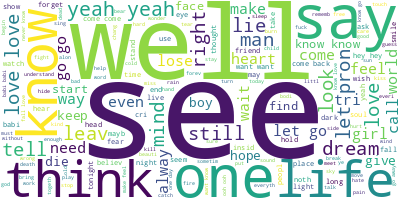

In [14]:
from wordcloud import WordCloud

lyr_column = list(data['Lyrics'])
total_string = ','.join(lyr_column)
wordcloud = WordCloud(background_color="white", max_words=5000)
wordcloud.generate(total_string)
wordcloud.to_image()

In [15]:
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

def sent2words(lyrics):
    all_lyrics = []
    for song in lyrics:
        all_lyrics.append(simple_preprocess(str(song)))
    return all_lyrics
        

In [16]:
lyrics_list = data['Lyrics'].tolist()
lyrics_words = list(sent2words(lyrics_list))

In [17]:
from gensim import corpora


id_word = corpora.Dictionary(lyrics_words)
data_corpus = [id_word.doc2bow(text) for text in lyrics_words]

Build LDA model: we need to define the number of topics and the parameters. We can try to identify topics with moods, and therefore following what we did in the dataset ground truth creation we can set the # of topics to 7. As for alpha and beta, they work as follows: <br>
- alpha = a priori document-topic distribution <br>
- eta = a priori word-topic distribution <br>
The gensim version of LDA model allows to specify both alpha and eta as 'auto', meaning that they are automatically learned from the corpus.

In [18]:
from gensim import models


In [19]:
#Create and save model
num_topics = 7

model = models.LdaMulticore(corpus=data_corpus, id2word=id_word, num_topics=num_topics)
model.save('LDA_model')

In [20]:
#Load model
model = models.LdaMulticore.load('LDA_model')

In [22]:
for i in range(0,num_topics):
    print(f'\nTopic #{i+1}:')
    print(model.print_topic(i, topn=15))




Topic #1:
0.017*"get" + 0.014*"know" + 0.013*"love" + 0.013*"want" + 0.012*"like" + 0.012*"go" + 0.011*"make" + 0.010*"never" + 0.009*"see" + 0.009*"come" + 0.008*"time" + 0.008*"let" + 0.007*"take" + 0.007*"one" + 0.007*"think"

Topic #2:
0.027*"love" + 0.021*"go" + 0.020*"know" + 0.018*"get" + 0.013*"like" + 0.012*"want" + 0.012*"feel" + 0.010*"life" + 0.009*"make" + 0.009*"tell" + 0.009*"let" + 0.009*"yeah" + 0.009*"say" + 0.008*"babi" + 0.008*"see"

Topic #3:
0.019*"know" + 0.017*"say" + 0.017*"want" + 0.015*"like" + 0.015*"get" + 0.013*"make" + 0.012*"go" + 0.010*"feel" + 0.010*"never" + 0.009*"yeah" + 0.009*"time" + 0.008*"love" + 0.008*"come" + 0.006*"one" + 0.006*"away"

Topic #4:
0.032*"love" + 0.017*"get" + 0.014*"go" + 0.012*"come" + 0.011*"one" + 0.011*"give" + 0.010*"feel" + 0.010*"take" + 0.009*"know" + 0.009*"life" + 0.008*"see" + 0.008*"heart" + 0.008*"want" + 0.008*"like" + 0.008*"time"

Topic #5:
0.021*"get" + 0.018*"know" + 0.015*"go" + 0.013*"want" + 0.011*"see" + 

First look: they don't seem to lead to good results, but let's try to visualize some information about each topic

In [23]:
import pyLDAvis
import pyLDAvis.gensim_models
#import pyLDAvis.gensim_models as gensimvis

vis=pyLDAvis.gensim_models.prepare(model, data_corpus, id_word)
pyLDAvis.display(vis)

/opt/homebrew/lib/python3.10/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


# Interpretation guide 

- Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.
- Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
- Red bars give the estimated number of times a given term was generated by a given topic. 
- The further the bubbles are away from each other, the more different they are.
- A good topic model will have big and non-overlapping bubbles scattered throughout the chart --> this is not always the case (topics 3, 4 and partially 1) <br>


In [24]:
# Evaluate the model in terms of coherence (good model = topics with high intra-topic coherence scores)
coh_mod = models.coherencemodel.CoherenceModel(model=model, corpus=data_corpus, coherence='u_mass')
coh_score = coh_mod.get_coherence()
coh_score_topic = coh_mod.get_coherence_per_topic()
print('Overall coherence:', coh_score)
print('Per topic coherence:', coh_score_topic)

Overall coherence: -1.1012320745216635
Per topic coherence: [-1.1683162176734716, -1.12889060890821, -1.1010949607528675, -1.0818570790922328, -1.0984060132820146, -1.0688266972602973, -1.0612329446825512]


The fact that the coherence value computed using u_mass score (which is the fastest/most efficient one) is negative is normal, since the expected range goes from -∞ to 0, with the coherence being better when closer to 0. <br>


## Ground truth comparison ??

Now let's try to compare the results obtained with LDA to the labels we have for the dataset. <br>
**Problem**: the labels probably won't match

In [35]:
lda_labels = list()
for bow in data_corpus:
    lda_labels.append(model[bow])
    

lda_labels

[[(3, 0.14524522), (4, 0.4194312), (5, 0.43163526)],
 [(0, 0.2071452),
  (2, 0.3748361),
  (3, 0.048837725),
  (4, 0.21852271),
  (5, 0.13417266),
  (6, 0.015404993)],
 [(0, 0.9961184)],
 [(0, 0.45836258), (1, 0.42559072), (5, 0.1083699)],
 [(4, 0.9925613)],
 [(0, 0.6789264), (1, 0.3116281)],
 [(4, 0.97533816)],
 [(2, 0.45378035), (4, 0.19425826), (5, 0.34255007)],
 [(1, 0.6837465), (4, 0.20784263), (6, 0.10344556)],
 [(6, 0.99299496)],
 [(1, 0.45121336), (2, 0.54131824)],
 [(0, 0.04378187), (2, 0.87504), (3, 0.059572488), (4, 0.019375037)],
 [(1, 0.08876952), (3, 0.18842195), (5, 0.71912616)],
 [(0, 0.17822029), (4, 0.076475285), (5, 0.74104923)],
 [(1, 0.9680853)],
 [(1, 0.15805027), (2, 0.1653813), (5, 0.052301552), (6, 0.6214693)],
 [(0, 0.21871941), (1, 0.75655663)],
 [(0, 0.16726586), (3, 0.82275337)],
 [(1, 0.5762618), (2, 0.18174216), (3, 0.059005413), (4, 0.18095799)],
 [(2, 0.994366)],
 [(3, 0.02893645), (5, 0.47019652), (6, 0.49276286)],
 [(3, 0.32169905), (6, 0.6690903)],
 

In [36]:
from operator import itemgetter
  
unique_labels = list()
for line in lda_labels:
    unique_labels.append(max(line, key=itemgetter(1))[0])

In [37]:
unique_labels

[5,
 2,
 0,
 0,
 4,
 0,
 4,
 2,
 1,
 6,
 2,
 2,
 5,
 5,
 1,
 6,
 1,
 3,
 1,
 2,
 6,
 6,
 0,
 5,
 3,
 4,
 3,
 4,
 5,
 1,
 1,
 5,
 5,
 3,
 3,
 2,
 3,
 5,
 1,
 4,
 5,
 0,
 5,
 5,
 5,
 0,
 3,
 5,
 0,
 0,
 3,
 2,
 4,
 5,
 0,
 0,
 2,
 0,
 5,
 1,
 2,
 0,
 6,
 3,
 5,
 1,
 0,
 4,
 1,
 1,
 5,
 0,
 5,
 1,
 0,
 1,
 5,
 2,
 5,
 3,
 1,
 5,
 5,
 5,
 4,
 2,
 4,
 0,
 5,
 2,
 3,
 2,
 1,
 5,
 5,
 2,
 5,
 5,
 6,
 6,
 5,
 2,
 1,
 2,
 0,
 5,
 3,
 4,
 3,
 6,
 0,
 3,
 2,
 4,
 2,
 4,
 6,
 0,
 0,
 3,
 5,
 2,
 1,
 5,
 3,
 3,
 1,
 5,
 2,
 3,
 6,
 5,
 3,
 6,
 1,
 5,
 5,
 4,
 3,
 0,
 6,
 1,
 5,
 4,
 3,
 5,
 2,
 5,
 4,
 1,
 5,
 5,
 5,
 1,
 5,
 3,
 3,
 4,
 4,
 1,
 6,
 2,
 3,
 6,
 5,
 3,
 3,
 3,
 1,
 1,
 5,
 4,
 2,
 4,
 4,
 1,
 5,
 5,
 1,
 0,
 4,
 4,
 4,
 5,
 5,
 5,
 6,
 1,
 1,
 1,
 6,
 1,
 1,
 6,
 3,
 5,
 5,
 1,
 4,
 0,
 5,
 3,
 5,
 1,
 5,
 1,
 1,
 5,
 6,
 3,
 2,
 5,
 6,
 4,
 0,
 2,
 5,
 5,
 2,
 4,
 5,
 5,
 2,
 5,
 5,
 2,
 4,
 2,
 2,
 5,
 6,
 4,
 2,
 5,
 4,
 4,
 6,
 5,
 4,
 6,
 5,
 2,
 1,
 5,
 3,
 1,
 1,
 5,
 4,
 3,


In [39]:
from collections import Counter

c_lda = Counter(unique_labels)
print(c_lda.items())

dict_items([(5, 9939), (2, 5167), (0, 3322), (4, 4550), (1, 6135), (6, 3696), (3, 5616)])


In [45]:
c_truth = Counter(list(labels['Label']))
print(c_truth.items())


dict_items([(0, 3598), (4, 11122), (3, 6338), (5, 9157), (6, 3099), (1, 2858), (2, 2253)])


Other idea: trigger words vs representative words for each topic